# **SAC Algorithm (Stable Baseline3)**

Use Stable Baselines3 to train a Soft Actor-Critic (SAC) agent on the MountainCarContinuous-v0 environment.

1. **Visualize SAC Algorithm**: Visualization of the SAC algorithm's architecture using Graphviz.
2. **Imports and Helper Functions**: Import libraries and define functions for saving videos, displaying animations, recording frames, and plotting rewards.
3. **Environment Setup and Model Initialization**: Initialize the environment and the model.
4. **SAC Model Configuration**: Initialize the environment and SAC model..
5. **Training the Model and Collecting Rewards**: Train the model while collecting rewards for plotting.
6. **Record and Save Video**: Record a video of the agent’s performance and display the video.
7. **Plot Rewards**: Plot actual rewards collected during training.
8. **Display Animation**: Create and display an animation of the recorded frames.
9. **Provide Download Option**: Provide a link to download the recorded video.

# Visualize A2C Algorithm

SAC Algorithm block diagram created successfully!


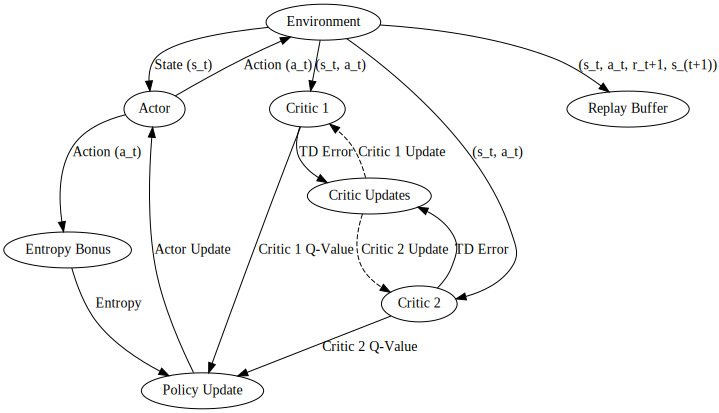

In [ ]:
# Visualize A2C Algorithm
import graphviz
graphviz.__version__, graphviz.version()
from graphviz import Digraph

# Define the graph
dot = Digraph(name='SAC_Algorithm', format='png')

# Add nodes
dot.node('environment', label='Environment')
dot.node('actor', label='Actor')
dot.node('critic1', label='Critic 1')
dot.node('critic2', label='Critic 2')
dot.node('policy_update', label='Policy Update')
dot.node('critic_updates', label='Critic Updates')
dot.node('entropy_bonus', label='Entropy Bonus')
dot.node('replay_buffer', label='Replay Buffer')

# Add edges with labels
dot.edge('environment', 'actor', label='State (s_t)')
dot.edge('actor', 'environment', label='Action (a_t)')
dot.edge('environment', 'critic1', label='(s_t, a_t)')
dot.edge('environment', 'critic2', label='(s_t, a_t)')
dot.edge('critic1', 'policy_update', label='Critic 1 Q-Value')
dot.edge('critic2', 'policy_update', label='Critic 2 Q-Value')
dot.edge('actor', 'entropy_bonus', label='Action (a_t)')
dot.edge('entropy_bonus', 'policy_update', label='Entropy')
dot.edge('policy_update', 'actor', label='Actor Update')
dot.edge('critic1', 'critic_updates', label='TD Error')
dot.edge('critic2', 'critic_updates', label='TD Error')
dot.edge('critic_updates', 'critic1', label='Critic 1 Update', style='dashed')
dot.edge('critic_updates', 'critic2', label='Critic 2 Update', style='dashed')
dot.edge('environment', 'replay_buffer', label='(s_t, a_t, r_t+1, s_(t+1))')

# Render the graph
dot.render('sac_diagram.png', view=True)

print("SAC Algorithm block diagram created successfully!")

dot

The **SAC (Soft Actor-Critic) algorithm** is a state-of-the-art reinforcement learning method that excels in handling continuous action spaces. It combines off-policy learning with deep learning to train both a policy (actor) and value functions (critics). Here’s a summary of the SAC algorithm along with a description of its dataflow based on the visualization:

**Algorithm Overview**

**Actor (Policy Network)**:

**Function**: The actor (policy network) generates actions based on the current state. It learns a stochastic policy that maximizes expected reward while encouraging exploration through entropy regularization.
**Training Objective**: Update the policy to maximize the expected return, adjusted by an entropy term to encourage exploration.

**Critics (Value Networks)**:

**Function**: Two critic networks estimate the Q-values (action-value functions) for given state-action pairs. They help in evaluating the quality of actions taken by the policy.
**Training Objective**: Minimize the temporal difference (TD) error between the predicted Q-values and the target Q-values derived from rewards and next state values.

**Replay Buffer**:

**Function**: Stores experience tuples of state, action, reward, and next state. This allows the algorithm to learn from past experiences and update the networks in an off-policy manner.

**Entropy Bonus**:

**Function**: Adds entropy regularization to the policy update to ensure sufficient exploration. This term is derived from the action distribution produced by the actor.

**Policy and Critic Update**s:

**Function**: The policy update uses the Q-values from critics and the entropy bonus to adjust the actor's policy. Critics are updated based on the TD errors.



**Data Flow**:

The SAC algorithm diagram represents the iterative data flow between different components of the algorithm:

**Environment → Acto**r: Provides state to the Actor.

**Actor → Environment**: Sends action to the Environment.

**Environment → Critics**: Supplies state-action pairs for Q-value estimation.

**Critics → Policy Update**: Sends Q-values for policy adjustment.

**Actor → Entropy Bonus**: Computes entropy based on actions for exploration.

**Entropy Bonus → Policy Update**: Adds entropy bonus to the policy update.

**Critics → Critic Updates**: Provides TD errors for Critic updates.

**Critic Updates → Critics**: Updates the Critic networks.

**Environment → Replay Buffer**: Stores transition data for off-policy learning.

This data flow encapsulates the SAC algorithm’s process of updating both Actor and Critic networks to optimize the policy and value function, enhancing decision-making in continuous action space tasks.

# Imports and Helper Functions

In [ ]:
# Install Stable Baselines3 and other dependencies
!pip install stable-baselines3[extra]
!pip install gym
!pip install opencv-python-headless  # Required for video saving

# Imports and Helper Functions

import numpy as np
import matplotlib.pyplot as plt
import gym
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback
from IPython.display import HTML, display
import cv2
from base64 import b64encode
import matplotlib.animation as animation
from google.colab import files
import torch  # Needed for any tensor operations, if required

# Helper function to convert numpy arrays to tensors
def t(x): return torch.from_numpy(x).float()

# Function to save video
def save_video(frames, filename, fps=30):
    height, width, _ = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(filename, fourcc, fps, (width, height))

    for frame in frames:
        video.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

    video.release()

# Function to display video in Google Colab
def display_video(video_path):
    with open(video_path, 'rb') as f:
        video_data = f.read()
    video_base64 = b64encode(video_data).decode()
    video_html = f"""
    <video width="600" controls>
        <source src="data:video/mp4;base64,{video_base64}" type="video/mp4">
    </video>
    """
    display(HTML(video_html))

# Function to create and display animation
def display_animation(frames, interval=50):
    fig, ax = plt.subplots()
    img = ax.imshow(frames[0])

    def update(frame):
        img.set_data(frame)
        return [img]

    ani = animation.FuncAnimation(fig, update, frames=frames, interval=interval)
    return HTML(ani.to_jshtml())

# Function to record frames for animation
def record_frames(model, env, num_episodes=1):
    frames = []

    for episode in range(num_episodes):
        obs = env.reset()
        done = False
        while not done:
            frames.append(env.render(mode='rgb_array'))
            action, _ = model.predict(obs)
            obs, _, done, _ = env.step(action)

    return frames

# Function to plot rewards
def plot_rewards(rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label='Total Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Rewards Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()


# Environment Setup and Model Initialization

In [ ]:
# Create and wrap the environment
# env = gym.make('MountainCarContinuous-v0', new_step_api=True)
# env = Monitor(env)  # Wrap environment to log episodes
# env = DummyVecEnv([lambda: env])  # Wrap in DummyVecEnv for compatibility with Stable Baselines3

from stable_baselines3.common.env_util import make_vec_env

# Create and wrap the environment
env = make_vec_env('MountainCarContinuous-v0', n_envs=1)

# Define SAC model
model = SAC('MlpPolicy', env, verbose=1)


Using cpu device


# Training the Model and Collecting Rewards

In [ ]:
# Variables to store episode rewards
episode_rewards = []

# Define a custom callback to collect rewards
class RewardCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardCallback, self).__init__(verbose)
        self.episode_rewards = []

    def _on_step(self) -> bool:
        # Get rewards at each step
        reward = self.locals['rewards'][0]
        self.episode_rewards.append(reward)
        return True

    def _on_training_end(self):
        # Optionally, handle anything after training ends
        pass

# Initialize callback and train the model
reward_callback = RewardCallback()
model.learn(total_timesteps=100000, callback=reward_callback)

# Store rewards for plotting
episode_rewards = reward_callback.episode_rewards

print("Training complete.")



Training complete.


# Record and Save Video

In [ ]:
# Record frames from the trained model
frames = record_frames(model, env, num_episodes=1)

# Save the video
video_path = '/content/sac_mountaincar_continuous.mp4'
save_video(frames, video_path)

# Display the recorded video
display_video(video_path)


# Plot Rewards

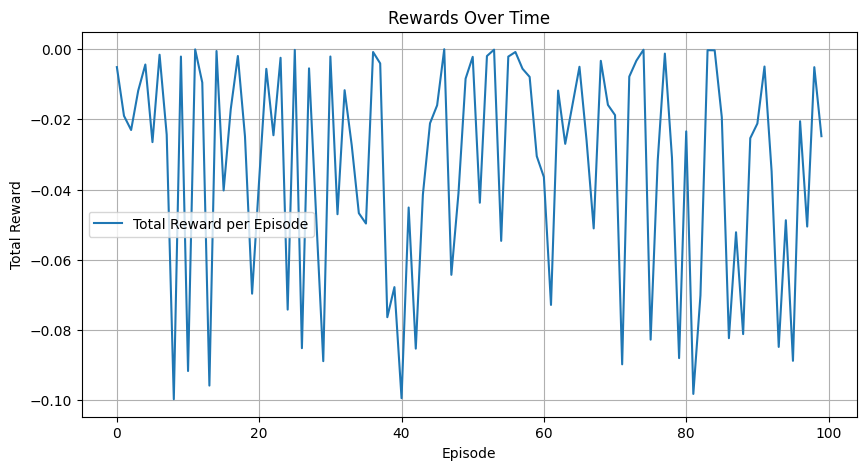

In [ ]:
# Plot the actual rewards collected during training
plot_rewards(episode_rewards)


# Display Animation

In [ ]:
# Create and display animation
animation_html = display_animation(frames, interval=50)
display(animation_html)


# Provide Download Option

In [ ]:
# Provide download option for the video
files.download('/content/sac_mountaincar_continuous.mp4')
